<a href="https://colab.research.google.com/github/athiq-ahmed/Pytorch/blob/master/Captcha_recognition_using_PyTorch_(Convolutional_RNN_%2B_CTC_Loss).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Sat Sep 12 10:56:01 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!curl -LO https://github.com/AakashKumarNain/CaptchaCracker/raw/master/captcha_images_v2.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   159  100   159    0     0    227      0 --:--:-- --:--:-- --:--:--   226
100 8863k  100 8863k    0     0  6070k      0  0:00:01  0:00:01 --:--:-- 39.8M


In [3]:
!unzip -qq captcha_images_v2.zip

### Config.py

In [20]:
DATA_DIR = '/content/captcha_images_v2'
BATCH_SIZE = 8
IMAGE_WIDTH = 300
IMAGE_HEIGHT = 75
NUM_WORKERS = 4
EPOCHS = 100
DEVICE = "cuda"

In [5]:
import glob
# glob.glob('/content/captcha_images_v2/*.png')

### Dataset.py

In [6]:
import albumentations # for augmentations
import torch
import numpy as np

from PIL import Image
from PIL import ImageFile

ImageFile.LOAD_TRUNCATED_IMAGES = True

In [7]:
class ClassificationDataset:
  def __init__(self, image_paths, targets, resize=None):
    self.image_paths = image_paths
    self.targets = targets
    self.resize = resize
    self.aug = albumentations.Compose([albumentations.Normalize(always_apply=True)])

  def __len__(self):
    return len(self.image_paths)

  def __getitem__(self, item):
    image = Image.open(self.image_paths[item]).convert("RGB")
    targets = self.targets[item]

    if self.resize is not None:
      image = image.resize((self.resize[1], self.resize[0]), resample=Image.BILINEAR)

    image = np.array(image)
    augmented = self.aug(image=image)
    image = augmented["image"]
    image = np.transpose(image, (2,0,1)).astype(np.float32)

    return {
        "images": torch.tensor(image, dtype=torch.float),
        "targets": torch.tensor(targets, dtype=torch.long)
    }

### engine.py

In [8]:
from tqdm import tqdm
import torch

def train_fn(model, data_loader, optimizer):
  model.train()
  fin_loss = 0
  tk = tqdm(data_loader, total=len(data_loader))
  for data in tk:
    for k, v in data.items():
      data[k] = v.to(DEVICE)
    optimizer.zero_grad()
    _, loss = model(**data)
    loss.backward()
    optimizer.step()
    fin_loss += loss
  return fin_loss / len(data_loader)

def eval_fn(model, data_loader):
  model.eval()
  fin_loss = 0
  fin_preds = []
  with torch.no_grad():
    tk = tqdm(data_loader, total=len(data_loader))
    for data in tk:
      for k, v in data.items():
        data[k] = v.to(DEVICE)

      preds, loss = model(**data)
      fin_loss += loss
      fin_preds.append(preds)
    return fin_preds, fin_loss / len(data_loader)

### model.py

In [13]:
import torch
from torch import nn
from torch.nn import functional as F

class CaptchaModel(nn.Module):
  def __init__(self, num_chars):
    super(CaptchaModel, self).__init__()
    self.conv_1 = nn.Conv2d(3, 128, kernel_size=(3,3), padding=(1,1))
    self.max_pool_1 = nn.MaxPool2d(kernel_size=(2,2))
    self.conv_2 = nn.Conv2d(128, 64, kernel_size=(3,3), padding=(1,1))
    self.max_pool_2 = nn.MaxPool2d(kernel_size=(2,2))

    self.linear_1 = nn.Linear(1152, 64)
    self.drop_1= nn.Dropout(0.2)

    self.gru = nn.GRU(64, 32, bidirectional=True, num_layers=2, dropout=0.25)
    self.output = nn.Linear(64, num_chars+1)

  def forward(self, images, targets=None):
    bs, c, h, w = images.size()
    # print(bs, c, h, w)
    x = F.relu(self.conv_1(images))
    # print(x.size())
    x = self.max_pool_1(x)
    # print(x.size())
    x = F.relu(self.conv_2(x))
    # print(x.size())
    x = self.max_pool_2(x) # [1, 64, 18, 75]
    # print(x.size())
    x = x.permute(0,3,1,2) # [1, 75, 64, 18]
    # print(x.size())
    x = x.view(bs, x.size(1), -1)
    # print(x.size()) #[1, 75, 1152]
    x = self.linear_1(x)
    x = self.drop_1(x)
    # print(x.size())
    x, _ = self.gru(x)
    # print(x.size())
    x = self.output(x)
    # print(x.size())
    x = x.permute(1,0,2)
    # print(x.size())

    if targets is not None:
      log_softmax_values = F.log_softmax(x, 2)
      input_lengths = torch.full(size=(bs,),fill_value=log_softmax_values.size(0),dtype=torch.int32)
      # print(input_lengths)
      target_lengths = torch.full(size=(bs,),fill_value=targets.size(1),dtype=torch.int32)
      # print(target_lengths)
      loss = nn.CTCLoss(blank=0)(log_softmax_values, targets, input_lengths, target_lengths)
      return x, loss

    return x, None

if __name__ == "__main__":
  cm = CaptchaModel(19)
  img = torch.rand(1,3,75,300)
  target = torch.randint(1,20,(1,5))
  x, loss = cm(img, target)


### train.py

In [21]:
import os
import glob
import torch
import numpy as np

from sklearn import preprocessing
from sklearn import model_selection
from sklearn import metrics

from pprint import pprint

def decode_predictions(preds, encoder):
  preds = preds.permute(1, 0 ,2)
  preds = torch.softmax(preds, 2)
  preds = torch.argmax(preds, 2)
  preds = preds.detach().cpu().numpy()
  cap_preds = []
  for j in range(preds.shape[0]):
    temp = []
    for k in preds[j, :]:
      k = k-1
      if k == -1:
        temp.append("`")
      else:
        temp.append(encoder.inverse_transform([k])[0])
    tp = "".join(temp)
    cap_preds.append(tp)
    return cap_preds


def run_traning():
  image_files = glob.glob('/content/captcha_images_v2/*.png')
  targets_orig = [x.split('/')[-1][:4] for x in image_files]  # "'../../../abcd.png"
  targets = [[c for c in x] for x in targets_orig]  # abcd --> [a, b, c, d]
  targets_flat = [c for clist in targets for c in clist]

  lbl_enc = preprocessing.LabelEncoder()
  lbl_enc.fit(targets_flat)
  targets_enc = [lbl_enc.transform(x) for x in targets]
  targets_enc = np.array(targets_enc) + 1


  (train_imgs, test_imgs, train_targets, test_targets, train_orig_targets, test_orig_targets) = \
  model_selection.train_test_split(image_files, targets_enc, targets_orig, test_size=0.1, random_state=42)

  train_dataset = ClassificationDataset(image_paths=train_imgs, targets=train_targets, resize=(IMAGE_HEIGHT, IMAGE_WIDTH))
  test_dataset = ClassificationDataset(image_paths=test_imgs, targets=test_targets, resize=(IMAGE_HEIGHT, IMAGE_WIDTH))

  train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True)
  test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=False)

  model = CaptchaModel(num_chars=len(lbl_enc.classes_))
  model.to(DEVICE)

  optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.8, patience=5, verbose=True)

  for epoch in range(EPOCHS):
    train_loss = train_fn(model, train_loader, optimizer)
    valid_preds, valid_loss = eval_fn(model, test_loader)

    valid_cap_preds=[]
    for vp in valid_preds:
      current_preds = decode_predictions(vp, lbl_enc)
      valid_cap_preds.extend(current_preds)
    pprint(list(zip(test_orig_targets, valid_cap_preds))[6:10])
    print(f'EPOCH:{epoch}, train_loss={train_loss}, valid_loss={valid_loss}')

  # print(targets)
  # print('*'*100)
  # print(np.unique(targets_flat))
  # print('*'*100)
  # print(targets_enc)
  # print('*'*100)
  # print(len(lbl_enc.classes_))


run_traning()

  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````````````````````````````````````````````````````````````````'),
 ('pe4x',
  '```````````````````````````````````````````````````````````````````````````'),
 ('cdmn',
  '```````````````````````````````````````````````````````````````````````````'),
 ('5mff',
  '```````````````````````````````````````````````````````````````````````````')]
EPOCH:0, train_loss=11.371249198913574, valid_loss=3.5133707523345947


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````````````````````````````````````````````````````````````````'),
 ('pe4x',
  '```````````````````````````````````````````````````````````````````````````'),
 ('cdmn',
  '```````````````````````````````````````````````````````````````````````````'),
 ('5mff',
  '```````````````````````````````````````````````````````````````````````````')]
EPOCH:1, train_loss=3.448848009109497, valid_loss=3.424778938293457


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````````````````````````````````````````````````````````````````'),
 ('pe4x',
  '```````````````````````````````````````````````````````````````````````````'),
 ('cdmn',
  '```````````````````````````````````````````````````````````````````````````'),
 ('5mff',
  '```````````````````````````````````````````````````````````````````````````')]
EPOCH:2, train_loss=3.393925189971924, valid_loss=3.3971197605133057


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````````````````````````````````````````````````````````````````'),
 ('pe4x',
  '```````````````````````````````````````````````````````````````````````````'),
 ('cdmn',
  '```````````````````````````````````````````````````````````````````````````'),
 ('5mff',
  '```````````````````````````````````````````````````````````````````````````')]
EPOCH:3, train_loss=3.3767404556274414, valid_loss=3.380378246307373


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````````````````````````````````````````````````````````````````'),
 ('pe4x',
  '```````````````````````````````````````````````````````````````````````````'),
 ('cdmn',
  '```````````````````````````````````````````````````````````````````````````'),
 ('5mff',
  '```````````````````````````````````````````````````````````````````````````')]
EPOCH:4, train_loss=3.365950107574463, valid_loss=3.366478443145752


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````````````````````````````````````````````````````````````````'),
 ('pe4x',
  '```````````````````````````````````````````````````````````````````````````'),
 ('cdmn',
  '```````````````````````````````````````````````````````````````````````````'),
 ('5mff',
  '```````````````````````````````````````````````````````````````````````````')]
EPOCH:5, train_loss=3.3596222400665283, valid_loss=3.360823631286621


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````````````````````````````````````````````````````````````````'),
 ('pe4x',
  '```````````````````````````````````````````````````````````````````````````'),
 ('cdmn',
  '```````````````````````````````````````````````````````````````````````````'),
 ('5mff',
  '```````````````````````````````````````````````````````````````````````````')]
EPOCH:6, train_loss=3.3519320487976074, valid_loss=3.3572237491607666


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````````````````````````````````````````````````````````````````'),
 ('pe4x',
  '```````````````````````````````````````````````````````````````````````````'),
 ('cdmn',
  '```````````````````````````````````````````````````````````````````````````'),
 ('5mff',
  '```````````````````````````````````````````````````````````````````````````')]
EPOCH:7, train_loss=3.3479392528533936, valid_loss=3.355492115020752


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````````````````````````````````````````````````````````````````'),
 ('pe4x',
  '```````````````````````````````````````````````````````````````````````````'),
 ('cdmn',
  '```````````````````````````````````````````````````````````````````````````'),
 ('5mff',
  '```````````````````````````````````````````````````````````````````````````')]
EPOCH:8, train_loss=3.3462016582489014, valid_loss=3.3533105850219727


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````````````````````````````````````````````````````````````````'),
 ('pe4x',
  '```````````````````````````````````````````````````````````````````````````'),
 ('cdmn',
  '```````````````````````````````````````````````````````````````````````````'),
 ('5mff',
  '```````````````````````````````````````````````````````````````````````````')]
EPOCH:9, train_loss=3.3415122032165527, valid_loss=3.3526623249053955


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````````````````````````````````````````````````````````````````'),
 ('pe4x',
  '```````````````````````````````````````````````````````````````````````````'),
 ('cdmn',
  '```````````````````````````````````````````````````````````````````````````'),
 ('5mff',
  '```````````````````````````````````````````````````````````````````````````')]
EPOCH:10, train_loss=3.3404452800750732, valid_loss=3.3494508266448975


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````````````````````````````````````````````````````````````````'),
 ('pe4x',
  '```````````````````````````````````````````````````````````````````````````'),
 ('cdmn',
  '```````````````````````````````````````````````````````````````````````````'),
 ('5mff',
  '```````````````````````````````````````````````````````````````````````````')]
EPOCH:11, train_loss=3.3382484912872314, valid_loss=3.349353313446045


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````````````````````````````````````````````````````````````````'),
 ('pe4x',
  '```````````````````````````````````````````````````````````````````````````'),
 ('cdmn',
  '```````````````````````````````````````````````````````````````````````````'),
 ('5mff',
  '```````````````````````````````````````````````````````````````````````````')]
EPOCH:12, train_loss=3.336104154586792, valid_loss=3.3451180458068848


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````````````````````````````````````````````````````````````````'),
 ('pe4x',
  '```````````````````````````````````````````````````````````````````````````'),
 ('cdmn',
  '```````````````````````````````````````````````````````````````````````````'),
 ('5mff',
  '```````````````````````````````````````````````````````````````````````````')]
EPOCH:13, train_loss=3.3358278274536133, valid_loss=3.342170000076294


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````````````````````````````````````````````````````````````````'),
 ('pe4x',
  '```````````````````````````````````````````````````````````````````````````'),
 ('cdmn',
  '```````````````````````````````````````````````````````````````````````````'),
 ('5mff',
  '```````````````````````````````````````````````````````````````````````````')]
EPOCH:14, train_loss=3.335745096206665, valid_loss=3.343142509460449


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````````````````````````````````````````````````````````````````'),
 ('pe4x',
  '```````````````````````````````````````````````````````````````````````````'),
 ('cdmn',
  '```````````````````````````````````````````````````````````````````````````'),
 ('5mff',
  '```````````````````````````````````````````````````````````````````````````')]
EPOCH:15, train_loss=3.334341049194336, valid_loss=3.3424971103668213


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````````````````````````````````````````````````````````````````'),
 ('pe4x',
  '```````````````````````````````````````````````````````````````````````````'),
 ('cdmn',
  '```````````````````````````````````````````````````````````````````````````'),
 ('5mff',
  '```````````````````````````````````````````````````````````````````````````')]
EPOCH:16, train_loss=3.3339779376983643, valid_loss=3.3407747745513916


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````````````````````````````````````````````````````````````````'),
 ('pe4x',
  '```````````````````````````````````````````````````````````````````````````'),
 ('cdmn',
  '```````````````````````````````````````````````````````````````````````````'),
 ('5mff',
  '```````````````````````````````````````````````````````````````````````````')]
EPOCH:17, train_loss=3.334237813949585, valid_loss=3.3433115482330322


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````````````````````````````````````````````````````````````````'),
 ('pe4x',
  '```````````````````````````````````````````````````````````````````````````'),
 ('cdmn',
  '```````````````````````````````````````````````````````````````````````````'),
 ('5mff',
  '```````````````````````````````````````````````````````````````````````````')]
EPOCH:18, train_loss=3.333299398422241, valid_loss=3.3422117233276367


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````````````````````````````````````````````````````````````````'),
 ('pe4x',
  '```````````````````````````````````````````````````````````````````````````'),
 ('cdmn',
  '```````````````````````````````````````````````````````````````````````````'),
 ('5mff',
  '```````````````````````````````````````````````````````````````````````````')]
EPOCH:19, train_loss=3.3324780464172363, valid_loss=3.3384499549865723


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````````````````````````````````````````````````````````````````'),
 ('pe4x',
  '```````````````````````````````````````````````````````````````````````````'),
 ('cdmn',
  '```````````````````````````````````````````````````````````````````````````'),
 ('5mff',
  '```````````````````````````````````````````````````````````````````````````')]
EPOCH:20, train_loss=3.3332369327545166, valid_loss=3.344095468521118


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````````````````````````````````````````````````````````````````'),
 ('pe4x',
  '```````````````````````````````````````````````````````````````````````````'),
 ('cdmn',
  '```````````````````````````````````````````````````````````````````````````'),
 ('5mff',
  '```````````````````````````````````````````````````````````````````````````')]
EPOCH:21, train_loss=3.3335330486297607, valid_loss=3.343035936355591


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````````````````````````````````````````````````````````````````'),
 ('pe4x',
  '```````````````````````````````````````````````````````````````````````````'),
 ('cdmn',
  '```````````````````````````````````````````````````````````````````````````'),
 ('5mff',
  '```````````````````````````````````````````````````````````````````````````')]
EPOCH:22, train_loss=3.331369638442993, valid_loss=3.3402340412139893


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````````````````````````````````````````````````````````````````'),
 ('pe4x',
  '```````````````````````````````````````````````````````````````````````````'),
 ('cdmn',
  '```````````````````````````````````````````````````````````````````````````'),
 ('5mff',
  '```````````````````````````````````````````````````````````````````````````')]
EPOCH:23, train_loss=3.3327877521514893, valid_loss=3.3450005054473877


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````````````````````````````````````````````````````````````````'),
 ('pe4x',
  '```````````````````````````````````````````````````````````````````````````'),
 ('cdmn',
  '```````````````````````````````````````````````````````````````````````````'),
 ('5mff',
  '```````````````````````````````````````````````````````````````````````````')]
EPOCH:24, train_loss=3.3330328464508057, valid_loss=3.345275402069092


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````````````````````````````````````````````````````````````````'),
 ('pe4x',
  '```````````````````````````````````````````````````````````````````````````'),
 ('cdmn',
  '```````````````````````````````````````````````````````````````````````````'),
 ('5mff',
  '```````````````````````````````````````````````````````````````````````````')]
EPOCH:25, train_loss=3.332531452178955, valid_loss=3.340134382247925


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````````````````````````````````````````````````````````````````'),
 ('pe4x',
  '```````````````````````````````````````````````````````````````````````````'),
 ('cdmn',
  '```````````````````````````````````````````````````````````````````````````'),
 ('5mff',
  '```````````````````````````````````````````````````````````````````````````')]
EPOCH:26, train_loss=3.332202196121216, valid_loss=3.3413727283477783


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````````````````````````````````````````````````````````````````'),
 ('pe4x',
  '```````````````````````````````````````````````````````````````````````````'),
 ('cdmn',
  '```````````````````````````````````````````````````````````````````````````'),
 ('5mff',
  '```````````````````````````````````````````````````````````````````````````')]
EPOCH:27, train_loss=3.3328745365142822, valid_loss=3.345604181289673


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````````````````````````````````````````````````````````````````'),
 ('pe4x',
  '```````````````````````````````````````````````````````````````````````````'),
 ('cdmn',
  '```````````````````````````````````````````````````````````````````````````'),
 ('5mff',
  '```````````````````````````````````````````````````````````````````````````')]
EPOCH:28, train_loss=3.3314309120178223, valid_loss=3.339472770690918


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````````````````````````````````````````````````````````````````'),
 ('pe4x',
  '```````````````````````````````````````````````````````````````````````````'),
 ('cdmn',
  '```````````````````````````````````````````````````````````````````````````'),
 ('5mff',
  '```````````````````````````````````````````````````````````````````````````')]
EPOCH:29, train_loss=3.3335022926330566, valid_loss=3.3392422199249268


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````````````````````````````````````````````````````````````````'),
 ('pe4x',
  '```````````````````````````````````````````````````````````````````````````'),
 ('cdmn',
  '```````````````````````````````````````````````````````````````````````````'),
 ('5mff',
  '```````````````````````````````````````````````````````````````````````````')]
EPOCH:30, train_loss=3.332658290863037, valid_loss=3.343931198120117


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````````````````````````````````````````````````````````````````'),
 ('pe4x',
  '```````````````````````````````````````````````````````````````````````````'),
 ('cdmn',
  '```````````````````````````````````````````````````````````````````````````'),
 ('5mff',
  '```````````````````````````````````````````````````````````````````````````')]
EPOCH:31, train_loss=3.3329899311065674, valid_loss=3.338630437850952


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````````````````````````````````````````````````````````````````'),
 ('pe4x',
  '```````````````````````````````````````````````````````````````````````````'),
 ('cdmn',
  '```````````````````````````````````````````````````````````````````````````'),
 ('5mff',
  '```````````````````````````````````````````````````````````````````````````')]
EPOCH:32, train_loss=3.331752061843872, valid_loss=3.3402907848358154


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````````````````````````````````````````````````````````````````'),
 ('pe4x',
  '```````````````````````````````````````````````````````````````````````````'),
 ('cdmn',
  '```````````````````````````````````````````````````````````````````````````'),
 ('5mff',
  '```````````````````````````````````````````````````````````````````````````')]
EPOCH:33, train_loss=3.332113027572632, valid_loss=3.342583656311035


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````````````````````````````````````````````````````````````````'),
 ('pe4x',
  '```````````````````````````````````````````````````````````````````````````'),
 ('cdmn',
  '```````````````````````````````````````````````````````````````````````````'),
 ('5mff',
  '```````````````````````````````````````````````````````````````````````````')]
EPOCH:34, train_loss=3.3326032161712646, valid_loss=3.348217487335205


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````````````````````````````````````````````````````````````````'),
 ('pe4x',
  '```````````````````````````````````````````````````````````````````````````'),
 ('cdmn',
  '```````````````````````````````````````````````````````````````````````````'),
 ('5mff',
  '```````````````````````````````````````````````````````````````````````````')]
EPOCH:35, train_loss=3.333110809326172, valid_loss=3.3451554775238037


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````````````````````````````````````````````````````````````````'),
 ('pe4x',
  '```````````````````````````````````````````````````````````````````````````'),
 ('cdmn',
  '```````````````````````````````````````````````````````````````````````````'),
 ('5mff',
  '```````````````````````````````````````````````````````````````````````````')]
EPOCH:36, train_loss=3.332702398300171, valid_loss=3.344883441925049


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````````````````````````````````````````````````````````````````'),
 ('pe4x',
  '```````````````````````````````````````````````````````````````````````````'),
 ('cdmn',
  '```````````````````````````````````````````````````````````````````````````'),
 ('5mff',
  '```````````````````````````````````````````````````````````````````````````')]
EPOCH:37, train_loss=3.332606792449951, valid_loss=3.340501546859741


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````````````````````````````````````````````````````````````````'),
 ('pe4x',
  '```````````````````````````````````````````````````````````````````````````'),
 ('cdmn',
  '```````````````````````````````````````````````````````````````````````````'),
 ('5mff',
  '```````````````````````````````````````````````````````````````````````````')]
EPOCH:38, train_loss=3.3299686908721924, valid_loss=3.3511435985565186


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````````````````````````````````````````````````````````````````'),
 ('pe4x',
  '```````````````````````````````````````````````````````````````````````````'),
 ('cdmn',
  '```````````````````````````````````````````````````````````````````````````'),
 ('5mff',
  '```````````````````````````````````````````````````````````````````````````')]
EPOCH:39, train_loss=3.318967819213867, valid_loss=3.344196081161499


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````````````````````````````````````````````````````````````````'),
 ('pe4x',
  '```````````````````````````````````````````````````````````````````````````'),
 ('cdmn',
  '```````````````````````````````````````````````````````````````````````````'),
 ('5mff',
  '``````````````````````````g````````````````````````````````````````````````')]
EPOCH:40, train_loss=3.244250535964966, valid_loss=3.1580145359039307


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````````````````````````````````````````````````````````````````'),
 ('pe4x',
  '`````````````````````````````b`````````````````````````````````````````````'),
 ('cdmn',
  '`````````````````d``````````````````````````f``````````````````````````````'),
 ('5mff',
  '``````````````````````````g````````````````````````````````````````````````')]
EPOCH:41, train_loss=3.0835745334625244, valid_loss=2.9781761169433594


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````````````````````````````````````````````````````````````````'),
 ('pe4x',
  '`````````````````````````````d`````````````````````````````````````````````'),
 ('cdmn',
  '`````````````````d`````````````````````````````````````````````````````````'),
 ('5mff',
  '``````````````````````````p````````````````````````````````````````````````')]
EPOCH:42, train_loss=2.9013872146606445, valid_loss=2.820131301879883


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````````````````````````````````````````````````````````````````'),
 ('pe4x',
  '`````````````````````````````b`````````````````````````````````````````````'),
 ('cdmn',
  '`````````````````b``````````````````````````d``````````````````````````````'),
 ('5mff',
  '``````````````````````````g````````````````````````````````````````````````')]
EPOCH:43, train_loss=2.7314984798431396, valid_loss=2.6336758136749268


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````````````````````````````````````````````````````````````````'),
 ('pe4x',
  '`````````````````````````````f`````````````````````````````````````````````'),
 ('cdmn',
  '`````````````````b``````````````````````````d``````````````````````````````'),
 ('5mff',
  '``````````````````````````g````````````````````````````````````````````````')]
EPOCH:44, train_loss=2.5608463287353516, valid_loss=2.5043790340423584


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````````````````````````````````3```````````````````````````````'),
 ('pe4x',
  '`````````````````````````````f`````````````````````````````````````````````'),
 ('cdmn',
  '`````````````````4``````````````````````````4``````````````````````````````'),
 ('5mff',
  '``````````````````````````g`````````````````````y``````````````````````````')]
EPOCH:45, train_loss=2.403614044189453, valid_loss=2.303825855255127


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````````````````````````````````3```````````````````````````````'),
 ('pe4x',
  '`````````````````````````````f`````````````````````````````````````````````'),
 ('cdmn',
  '`````````````````4``````````````````````````d``````````````````````````````'),
 ('5mff',
  '``````````````````````````g````````````````````````````````````````````````')]
EPOCH:46, train_loss=2.2448618412017822, valid_loss=2.170290470123291


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````````````````````````````````3```````````````````````````````'),
 ('pe4x',
  '```````````````````n`````````f`````````````````````````````````````````````'),
 ('cdmn',
  '`````````````````4```````````````n``````````d``````````````````````````````'),
 ('5mff',
  '``````````````````````````g`````````````````````y``````````````````````````')]
EPOCH:47, train_loss=2.073263645172119, valid_loss=1.9621316194534302


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````````````````````````````````3```````````````````````````````'),
 ('pe4x',
  '````````````````2``n````n````f`````````````````````````````````````````````'),
 ('cdmn',
  '`````````````````4```````````````n``````````d``````````````````````````````'),
 ('5mff',
  '``````````````````````````g`````````````````````y``````````````````````````')]
EPOCH:48, train_loss=1.8908203840255737, valid_loss=1.8222397565841675


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````````````````````````````````3```````````````````````````````'),
 ('pe4x',
  '````````````````2``n````n````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4```````````````n`````````````````````````````````````````'),
 ('5mff',
  '``````````````````````````g`````````````````````y``````````````````````````')]
EPOCH:49, train_loss=1.672113299369812, valid_loss=1.647823691368103


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````````````````````````````````3```````````````````````````````'),
 ('pe4x',
  '````````````````2````````````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4```````````````n``````````d``````````````````````````````'),
 ('5mff',
  '``````````````````````````g`````````````````````y``````````````````````````')]
EPOCH:50, train_loss=1.487390160560608, valid_loss=1.4448264837265015


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '``````````````````````````````6````````````3```````````````````````````````'),
 ('pe4x',
  '````````````````2````````````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4```````````````n`````````````````````````````````````````'),
 ('5mff',
  '``````````````````````````g````````````````````````````````````````````````')]
EPOCH:51, train_loss=1.341194987297058, valid_loss=1.2623134851455688


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '``````````````````````````````66```````````3```````````````````````````````'),
 ('pe4x',
  '````````````````2````````````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4```````````````n`````````````````````````````````````````'),
 ('5mff',
  '``````````````````````````g````````````````````````````````````````````````')]
EPOCH:52, train_loss=1.1960210800170898, valid_loss=1.0315539836883545


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '``````````````````````````````66```````````3```````````````````````````````'),
 ('pe4x',
  '````````````````2```````n````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4````e``````````n`````````````````````````````````````````'),
 ('5mff',
  '``````````````````````````g````````````````````````````````````````````````')]
EPOCH:53, train_loss=1.0552810430526733, valid_loss=0.9117866158485413


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '``````````````````````````````6````````````3```````````````````````````````'),
 ('pe4x',
  '````````````````2````````````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4```````````````n`````````````````````````````````````````'),
 ('5mff',
  '````````````````x`````````g````````````````````````````````````````````````')]
EPOCH:54, train_loss=0.9754149317741394, valid_loss=0.8546725511550903


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '``````````````````````````````66```````````3```````````````````````````````'),
 ('pe4x',
  '````````````````2````````````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4````e``````````n`````````````````````````````````````````'),
 ('5mff',
  '````````````````x`````````g```````````````x````````````````````````````````')]
EPOCH:55, train_loss=0.892179012298584, valid_loss=0.8016669750213623


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '``````````````````````x```````66```````````3```````````````````````````````'),
 ('pe4x',
  '````````````````2```````n````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4````e``````````n`````````````````````````````````````````'),
 ('5mff',
  '````````````````x`````````g```````````````x````````````````````````````````')]
EPOCH:56, train_loss=0.8062667846679688, valid_loss=0.7380469441413879


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '``````````````````````````````66```````````3```````````````````````````````'),
 ('pe4x',
  '````````````````2```````n````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4````e``````````n`````````````````````````````````````````'),
 ('5mff',
  '````````````````x`````````g```````````````x````````````````````````````````')]
EPOCH:57, train_loss=0.770309329032898, valid_loss=0.6611044406890869


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '``````````````````````````````66```````````3```````````````````````````````'),
 ('pe4x',
  '````````````````2```````n````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4```ee``````````n``````````d``````````````````````````````'),
 ('5mff',
  '````````````````x`````````g```````````````x````````````````````````````````')]
EPOCH:58, train_loss=0.7332639098167419, valid_loss=0.8064177632331848


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '``````````````````````````````66```````````3```````````````````````````````'),
 ('pe4x',
  '````````````````2````````````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4````e``````````n`````````````````````````````````````````'),
 ('5mff',
  '````````````````x`````````g```````````````x````````````````````````````````')]
EPOCH:59, train_loss=0.6793522834777832, valid_loss=0.6130309104919434


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '``````````````````````````````6````````````3```````````````````````````````'),
 ('pe4x',
  '````````````````2```````n````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4````e``````````n```````7``d``````````````````````````````'),
 ('5mff',
  '````````````````x`````````g```````````````x````````````````````````````````')]
EPOCH:60, train_loss=0.630101203918457, valid_loss=0.6612574458122253


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '``````````````````````````````66```````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2```````n````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4````e``````````n`````````````````````````````````````````'),
 ('5mff',
  '````````````````x`````````g```````````````x````````````````````````````````')]
EPOCH:61, train_loss=0.59366375207901, valid_loss=0.5067625045776367


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '``````````````````````c```````66```````````3```````````````````````````````'),
 ('pe4x',
  '````````````````2```````n````f`````````2```6```````````````````````````````'),
 ('cdmn',
  '`````````````````4````e``````````n```````7``d``````````````````````````````'),
 ('5mff',
  '````````````````x`````````g```````````````x````````````````````````````````')]
EPOCH:62, train_loss=0.5694299340248108, valid_loss=0.6642388105392456


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '``````````````````````````````66```````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2```````n````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4````e``````````n```````7`````````````````````````````````'),
 ('5mff',
  '````````````````x`````````g```````````````x````````````````````````````````')]
EPOCH:63, train_loss=0.5333716869354248, valid_loss=0.5146322250366211


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '``````````````````````````````6````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2````````````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4````e``````````n`````````````````````````````````````````'),
 ('5mff',
  '````````````````x`````````g```````````````x````````````````````````````````')]
EPOCH:64, train_loss=0.47955086827278137, valid_loss=0.5150200724601746


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '``````````````````````c```````66```````````3```````````````````````````````'),
 ('pe4x',
  '````````````````2```````n````f`````````2```6```````````````````````````````'),
 ('cdmn',
  '`````````````````4```ee``````````n```````7`````````````````````````````````'),
 ('5mff',
  '````````````````xx````````g````c``````````x````````````````````````````````')]
EPOCH:65, train_loss=0.4772196412086487, valid_loss=0.47115975618362427


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '``````````````````````c```````6````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2```````n````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4```ee``````````n```````7`````````````````````````````````'),
 ('5mff',
  '````````````````xx````````g```````````````x````````````````````````````````')]
EPOCH:66, train_loss=0.46403491497039795, valid_loss=0.44827693700790405


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '``````````````````````````````66```````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2````````````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4```ee``````````n`````````````````````````````````````````'),
 ('5mff',
  '````````````````cx````````g```````````````x````````````````````````````````')]
EPOCH:67, train_loss=0.44264480471611023, valid_loss=0.4936351478099823


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '``````````````````````c```````66```````````8```````````````````````````````'),
 ('pe4x',
  '````````````````22``````n````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4```ee``````````n```````7`````````````````````````````````'),
 ('5mff',
  '````````````````xx````````g````c``````````x````````````````````````````````')]
EPOCH:68, train_loss=0.4083692729473114, valid_loss=0.45092734694480896


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '``````````````````````c```````66```````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2```````n````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4````e``````````n```````7`````````````````````````````````'),
 ('5mff',
  '````````````````xx````````g```````````````x````````````````````````````````')]
EPOCH:69, train_loss=0.41678398847579956, valid_loss=0.4551508128643036


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '``````````````````````c```````6````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2```````n````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4```ee``````````n`````````````````````````````````````````'),
 ('5mff',
  '````````````````xx````````g```````````````x````````````````````````````````')]
EPOCH:70, train_loss=0.3655134439468384, valid_loss=0.3946106731891632


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '``````````````````````c```````6````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2```````n````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4```ee``````````n```````7`````````````````````````````````'),
 ('5mff',
  '````````````````xx````````g```````````````x````````````````````````````````')]
EPOCH:71, train_loss=0.36848366260528564, valid_loss=0.43153640627861023


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '``````````````````````c```````66```````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2````````````f`````````2```6```````````````````````````````'),
 ('cdmn',
  '`````````````````4```ee``````````n```````7`````````````````````````````````'),
 ('5mff',
  '````````````````xx````````g````c``````````x````````````````````````````````')]
EPOCH:72, train_loss=0.3627966344356537, valid_loss=0.4324544668197632


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '``````````````````````c```````6````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2```````n````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4```ee``````````n```````7`````````````````````````````````'),
 ('5mff',
  '````````````````xx````````g```````````````x````````````````````````````````')]
EPOCH:73, train_loss=0.35021811723709106, valid_loss=0.3883439302444458


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '``````````````````````````````6````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2````````````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4```````````````n```````7`````````````````````````````````'),
 ('5mff',
  '````````````````xx````````g```````````````x````````````````````````````````')]
EPOCH:74, train_loss=0.31181907653808594, valid_loss=0.6515892148017883


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '``````````````````````c```````6````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2```````n````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4```ec``````````n```````7`````````````````````````````````'),
 ('5mff',
  '````````````````xx````````g```````````````x````````````````````````````````')]
EPOCH:75, train_loss=0.32469308376312256, valid_loss=0.35640379786491394


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '``````````````````````c```````6````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2```````n````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4```ee``````````n```````7`````````````````````````````````'),
 ('5mff',
  '````````````````xx````````g```````````````x````````````````````````````````')]
EPOCH:76, train_loss=0.28887882828712463, valid_loss=0.41538137197494507


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '``````````````````````c```````66```````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2```````n````f`````````2```6```````````````````````````````'),
 ('cdmn',
  '`````````````````4```ee``````````n```````7``d``````````````````````````````'),
 ('5mff',
  '````````````````xx````````g```````````````x````````````````````````````````')]
EPOCH:77, train_loss=0.3062651753425598, valid_loss=0.4129642844200134


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '````````````````x`````c```````66```````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2```````n````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4```ee``````````n```````7`````````````````````````````````'),
 ('5mff',
  '````````````````xx````````g```````````````x````````````````````````````````')]
EPOCH:78, train_loss=0.3068808615207672, valid_loss=0.4171909987926483


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '````````````````x`````c```````66```````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2```````n````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4```ee``````````n```````7`````````````````````````````````'),
 ('5mff',
  '````````````````xx````````g```````````````x````````````````````````````````')]
EPOCH:79, train_loss=0.2806454002857208, valid_loss=0.3978014588356018


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '``````````````````````c```````66```````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2```````n````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4```ee``````````n```````7`````````````````````````````````'),
 ('5mff',
  '````````````````xx````````g```````````````x````````````````````````````````')]
EPOCH:80, train_loss=0.26388102769851685, valid_loss=0.38413792848587036


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '``````````````````````c```````66```````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2```````n````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4```ee``````````n```````7`````````````````````````````````'),
 ('5mff',
  '````````````````xx````````g```````````````x````````````````````````````````')]
EPOCH:81, train_loss=0.2593964636325836, valid_loss=0.4183964133262634


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '````````````````x`````c```````66```````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2```````m````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4```ee``````````n```````7`````````````````````````````````'),
 ('5mff',
  '````````````````xx````````g```````````````x````````````````````````````````')]
EPOCH:82, train_loss=0.24800744652748108, valid_loss=0.3577536940574646


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '``````````````````````c```````66```````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2```````n````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4```ec``````````n```````7`````````````````````````````````'),
 ('5mff',
  '````````````````xx````````g```````````````x````````````````````````````````')]
EPOCH:83, train_loss=0.2380218356847763, valid_loss=0.3759763836860657


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '````````````````x`````c```````66```````````8```````````````````````````````'),
 ('pe4x',
  '````````````````22``````n````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4```ee``````````n``````77`````````````````````````````````'),
 ('5mff',
  '````````````````xx````````g```````````````x````````````````````````````````')]
EPOCH:84, train_loss=0.22894464433193207, valid_loss=0.41362178325653076


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '````````````````x`````c```````6````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2```````n````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4```ec``````````n``````77`````````````````````````````````'),
 ('5mff',
  '````````````````xx````````g```````````````x````````````````````````````````')]
EPOCH:85, train_loss=0.26990020275115967, valid_loss=0.37103211879730225


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '``````````````````````c```````66```````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2```````n````f`````````2```6```````````````````````````````'),
 ('cdmn',
  '`````````````````4```ee``````````n```````7`````````````````````````````````'),
 ('5mff',
  '````````````````xx````````g```````````````x````````````````````````````````')]
EPOCH:86, train_loss=0.22131532430648804, valid_loss=0.36372479796409607


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '``````````````````````c```````66```````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2```````n````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4```ee``````````n```````7`````````````````````````````````'),
 ('5mff',
  '````````````````xx````````g```````````````x````````````````````````````````')]
EPOCH:87, train_loss=0.22001014649868011, valid_loss=0.31543615460395813


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '``````````````````````c```````6````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2```````n````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4```ee``````````n```````7`````````````````````````````````'),
 ('5mff',
  '````````````````xx````````g```````````````x````````````````````````````````')]
EPOCH:88, train_loss=0.22044415771961212, valid_loss=0.3637893497943878


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '````````````````x`````c```````66```````````8```````````````````````````````'),
 ('pe4x',
  '````````````````22``````n````f`````````2```6```````````````````````````````'),
 ('cdmn',
  '`````````````````4```ee``````````n```````7`````````````````````````````````'),
 ('5mff',
  '````````````````xx````````g```````````````x````````````````````````````````')]
EPOCH:89, train_loss=0.22086039185523987, valid_loss=0.41547226905822754


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '````````````````x`````c```````66```````````8```````````````````````````````'),
 ('pe4x',
  '````````````````22``````n````f`````````2```6```````````````````````````````'),
 ('cdmn',
  '`````````````````4```ee``````````n```````7`````````````````````````````````'),
 ('5mff',
  '````````````````xx````````g```````````````x````````````````````````````````')]
EPOCH:90, train_loss=0.21424749493598938, valid_loss=0.48197847604751587


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '````````````````x`````c```````66```````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2```````n````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4```ee``````````n```````7`````````````````````````````````'),
 ('5mff',
  '````````````````xx````````g```````````````x````````````````````````````````')]
EPOCH:91, train_loss=0.1974186897277832, valid_loss=0.3916831910610199


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '````````````````x`````c```````66```````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2```````n````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4```ee``````````n```````7`````````````````````````````````'),
 ('5mff',
  '````````````````xx````````g```````````````x````````````````````````````````')]
EPOCH:92, train_loss=0.18806253373622894, valid_loss=0.3819413185119629


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '``````````````````````c```````6````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2````````````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4```e```````````n```````7`````````````````````````````````'),
 ('5mff',
  '````````````````xx````````g```````````````x````````````````````````````````')]
EPOCH:93, train_loss=0.1920952945947647, valid_loss=0.43951642513275146


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '````````````````x`````c```````66```````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2```````n````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4```ee``````````n```````7`````````````````````````````````'),
 ('5mff',
  '````````````````xx````````g```````````````x````````````````````````````````')]
EPOCH:94, train_loss=0.18009920418262482, valid_loss=0.4309747815132141


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '````````````````x`````c```````66```````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2```````n````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4```ee``````````n```````7`````````````````````````````````'),
 ('5mff',
  '````````````````xx````````g```````````````x````````````````````````````````')]
EPOCH:95, train_loss=0.19819024205207825, valid_loss=0.41334331035614014


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '````````````````x`````c```````6````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2```````n````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4```ee``````````n```````7`````````````````````````````````'),
 ('5mff',
  '````````````````xx````````g```````````````x````````````````````````````````')]
EPOCH:96, train_loss=0.170089989900589, valid_loss=0.4275456666946411


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '``````````````````````c```````6````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2```````n````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4```ee``````````n```````7`````````````````````````````````'),
 ('5mff',
  '````````````````xx````````g```````````````x````````````````````````````````')]
EPOCH:97, train_loss=0.16403265297412872, valid_loss=0.431247740983963


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '````````````````x`````c```````66```````````8```````````````````````````````'),
 ('pe4x',
  '````````````````22``````n````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4```ee``````````n```````7`````````````````````````````````'),
 ('5mff',
  '````````````````xx````````g```````````````x````````````````````````````````')]
EPOCH:98, train_loss=0.19978314638137817, valid_loss=0.3776453733444214


100%|██████████| 13/13 [00:00<00:00, 39.64it/s]

[('gc27',
  '````````````````x`````c```````66```````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2```````n````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4```ee``````````n```````7`````````````````````````````````'),
 ('5mff',
  '````````````````xx````````g```````````````x````````````````````````````````')]
EPOCH:99, train_loss=0.16283512115478516, valid_loss=0.3891858160495758


### view.py

In [11]:
import os
import glob
import torch
import numpy as np

from sklearn import preprocessing
from sklearn import model_selection
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline

image_files = glob.glob('/content/captcha_images_v2/*.png')
targets_orig = [x.split('/')[-1][:4] for x in image_files]  # "'../../../abcd.png"
targets = [[c for c in x] for x in targets_orig]  # abcd --> [a, b, c, d]
targets_flat = [c for clist in targets for c in clist]

lbl_enc = preprocessing.LabelEncoder()
lbl_enc.fit(targets_flat)
targets_enc = [lbl_enc.transform(x) for x in targets]
targets_enc = np.array(targets_enc) + 1


(train_imgs, test_imgs, train_targets, test_targets, train_orig_targets, test_orig_targets) = \
model_selection.train_test_split(image_files, targets_enc, targets_orig, test_size=0.1, random_state=42)

train_dataset = ClassificationDataset(image_paths=train_imgs, targets=train_targets, resize=(IMAGE_HEIGHT, IMAGE_WIDTH))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


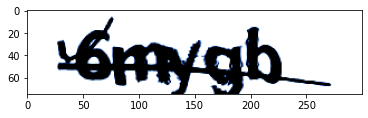

In [12]:
# train_dataset[0]
npimg = train_dataset[200]["images"].numpy()
# npimg
# npimg.shape
# np.transpose(npimg, (1,2,0)).shape
plt.imshow(np.transpose(npimg, (1,2,0)))